In [1]:
%load_ext autoreload
%autoreload 2
# Set HuggingFace cache directory to scratch to save space.
import os
os.environ['HUGGINGFACE_HUB_CACHE'] = '/scratch/' + os.environ['USER'] + '/huggingface_cache'
CACHE_DIR = '/scratch/' + os.environ['USER'] + '/huggingface_cache'

In [2]:
import math

import hnswlib
import torch
import torch.nn as nn
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
import time

In [3]:
model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype="auto", trust_remote_code=True).to('cuda')
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
model.model.layers[0].mlp.fc1.weight.shape, model.model.layers[0].mlp.fc2.weight.shape

(torch.Size([10240, 2560]), torch.Size([2560, 10240]))

In [52]:
import numpy as np

"""
from transformers.activations import ACT2FN

class PhiMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.activation_fn = ACT2FN[config.hidden_act]
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.fc1(hidden_states)
        hidden_states = self.activation_fn(hidden_states)
        hidden_states = self.fc2(hidden_states)
        return hidden_states
"""

debug_acts = None

class SparseMLP(torch.nn.Module):
    def __init__(self, mlp, num_neighbors, p=None):
        super().__init__()
        
        # Use inner product as a "distance metric". This is actually perfect for our case though,
        # where MLP activations are scaled according to inner product.
        self.mlp = mlp
        if p is not None:
            self.p = p
        else:
            self.p = p = hnswlib.Index(space='ip', dim=mlp.fc1.in_features + 1)

            # Add weight matrix to encoder.
            p.init_index(max_elements=mlp.fc1.out_features)

            ids = np.arange(mlp.fc1.out_features)

            start_time = time.time()

            # mlp.fc1.weight.shape: [10240, 2560]
            # we add a bias so we can query for that inner product as well
            match_vecs = np.concatenate([
                mlp.fc1.weight.detach().cpu().numpy(),
                mlp.fc1.bias.detach().cpu().unsqueeze(-1).numpy(),
            ], axis=-1)
            p.add_items(match_vecs, ids)

            end_time = time.time()

            print(f"Initialized HNSW database in {end_time - start_time:.4f}s")

        # ef should be greater than k.
        # it is the size of the list used during nearest neighbor search.
        p.set_ef(int(num_neighbors * 2))
        self.num_neighbors = num_neighbors
    
    def forward(self, hidden_states: torch.Tensor):
        global debug_acts
        
        hidden_states_np = np.ones((hidden_states.shape[0], hidden_states.shape[1], hidden_states.shape[2] + 1))
        hidden_states_np[..., :-1] = hidden_states.detach().cpu().numpy()
        # Flatten.
        hidden_states_np_flat = hidden_states_np.reshape(-1, hidden_states_np.shape[-1])
        # Calculate nearest neighbors.
        # Discard these distances, as they might be inaccurate. TODO: Quantify this?
        # print("Performing KNN query.")
        start = time.time()
        labels_flat, _distances = self.p.knn_query(hidden_states_np_flat, k=self.num_neighbors)
        labels_flat = torch.tensor(labels_flat.astype(np.int64), device="cuda").long()
        labels = labels_flat.view((hidden_states.shape[0], hidden_states.shape[1], self.num_neighbors))
        end = time.time()
        # print(f"KNN query finished: {end - start:.4f}s")
        # labels = labels.reshape((hidden_states.shape[0], hidden_states.shape[1], num_neighbors))
        
        # TODO: Cache contributions from MLP neurons with 0 bias?
        mlp = self.mlp
        # activations_recons_flat = torch.zeros((hidden_states.shape[0] * hidden_states.shape[1], mlp.fc1.bias.shape[0]), device=mlp.fc1.bias.device, dtype=mlp.fc1.bias.dtype)
        
        activations_recons = torch.zeros((hidden_states.shape[0], hidden_states.shape[1], mlp.fc1.bias.shape[0]), device=mlp.fc1.bias.device, dtype=mlp.fc1.bias.dtype)
        activations_recons -= 0.28
        
        # Construct activations manually.
        for batch_i in range(hidden_states.shape[0]):
            for seq_i in range(hidden_states.shape[1]):
                # for nearest_fc1_vector_id in range(10240):
                for label_i in range(self.num_neighbors):
                    nearest_fc1_vector_id = labels[batch_i, seq_i, label_i]
                    activations_recons[batch_i, seq_i, nearest_fc1_vector_id] = mlp.fc1.weight.data[nearest_fc1_vector_id, :] @ hidden_states[batch_i, seq_i]
        
        activations_recons[:] += mlp.fc1.bias.data.clone()
        
        true_activations = mlp.fc1(hidden_states)
        
        debug_acts = (activations_recons, true_activations)
        
        # print(activations_recons)
        # print(true_activations)
        
        # [batch_size, seqlen, hidden dims size]
        
#         labels_flatter = labels_flat.view(-1)
        
#         mlp_selected = mlp.fc1.weight.data[:, labels_flatter].view(-1, hidden_states.shape[0], self.num_neighbors)
        
#         print(labels_flatter.shape, mlp_selected.shape)
#         return
        
#         # (out_dims, in_dims) x (n_tokens, in_dims) -> (n_tokens, out_dims)
#         activations_recons_flat[:, labels_flat] += torch.einsum("oi,ni->no", mlp.fc1.weight.data[:, labels_flat], hidden_states)
#         activations_flat = mlp.activation_fn(activations_recons_flat)
#         print(activations_recons_flat.shape, activations_flat.shape)
#         activations = activations_flat.view(hidden_states.shape[0], hidden_states.shape[1], mlp.fc1.bias.shape[0])
#         print(activations.shape)
        
        # Construct output. As I mentioned earlier, we can cache contributions from activations that are common constants.
        reconstructed_activation = torch.einsum("oi,bsi->bso", mlp.fc2.weight, mlp.activation_fn(activations_recons)) + mlp.fc2.bias
        
        end_2 = time.time()
        print(f"Total sparse runtime: {end_2 - start:.4f}s")
        
        mlp_start = time.time()
        original_activation = mlp(hidden_states)
        mlp_end = time.time()
        
        print(f"MLP runtime: {mlp_end - mlp_start:.4f}s")
        
        pre = torch.abs(true_activations - activations_recons).sum().item()
        post = torch.abs(mlp.activation_fn(true_activations) - mlp.activation_fn(activations_recons)).sum().item()
        out = torch.abs(original_activation - reconstructed_activation).sum().item()
        print(f"err: {pre=:.4f} {post=:.4f} {out=:.4f}")
        
        return reconstructed_activation
    

In [ ]:
# While this doesn't look great, let's try to do this for later layers. Maybe it's just very bad for the first 1-2 layers only.

In [7]:
original_mlps = [model.model.layers[i].mlp for i in range(len(model.model.layers))]

In [57]:
class ZeroMLP(torch.nn.Module):
    def __init__(self, mlp):
        super().__init__()
        
        self.mlp = mlp
        
    def forward(self, hidden_states):
        return torch.zeros_like(hidden_states)

In [68]:
cache_all = []
for mlp_i in range(32):
    if 20 <= mlp_i <= 24:
        cache_all.append(cache[mlp_i - 20])
    else:
        cache_all.append(SparseMLP(original_mlps[mlp_i], num_neighbors))


Initialized HNSW database in 20.8995s
Initialized HNSW database in 29.8869s
Initialized HNSW database in 30.0281s
Initialized HNSW database in 17.2247s
Initialized HNSW database in 23.6389s
Initialized HNSW database in 20.9169s
Initialized HNSW database in 21.1710s
Initialized HNSW database in 22.7189s
Initialized HNSW database in 33.1878s
Initialized HNSW database in 28.4556s
Initialized HNSW database in 34.6641s
Initialized HNSW database in 34.8667s
Initialized HNSW database in 34.6308s
Initialized HNSW database in 33.8913s
Initialized HNSW database in 33.4640s
Initialized HNSW database in 34.4231s
Initialized HNSW database in 33.7416s
Initialized HNSW database in 36.4866s
Initialized HNSW database in 35.4536s
Initialized HNSW database in 34.1627s
Initialized HNSW database in 43.3786s
Initialized HNSW database in 45.1103s
Initialized HNSW database in 44.0910s
Initialized HNSW database in 44.1231s
Initialized HNSW database in 43.8215s
Initialized HNSW database in 43.0289s
Initialized 

In [69]:
for i in range(len(cache_all)):
    cache_all[i].p.save_index(f"index_{i}.bin")


In [58]:
cache = [model.model.layers[mlp_i].mlp for mlp_i in replace_mlps]

In [65]:
replace_mlps = [20, 21, 22, 23, 24]
num_neighbors = 50

# cache = [model.model.layers[mlp_i].mlp for mlp_i in replace_mlps]

for mlp_i in range(len(model.model.layers)):
    if mlp_i in replace_mlps:
        cur = model.model.layers[mlp_i].mlp
        model.model.layers[mlp_i].mlp = cache[replace_mlps.index(mlp_i)]
        # model.model.layers[mlp_i].mlp = ZeroMLP(cur)
        # model.model.layers[mlp_i].mlp = SparseMLP(original_mlps[mlp_i], num_neighbors, p=cur.p if type(cur) != type(model.model.layers[0].mlp) else None)
    else:
        # if we change replace_mlps, then restore the old mlp layer
        model.model.layers[mlp_i].mlp = original_mlps[mlp_i]


In [62]:
smlp = model.model.layers[23].mlp

In [66]:
# test.

tokens = tokenizer("Instruct: Write a quick song about bricks.\n\nResponse:", return_tensors="pt").to('cuda')
output = model.generate(**tokens, max_new_tokens=1000)
print(tokenizer.decode(output[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Total sparse runtime: 0.0921s
MLP runtime: 0.0002s
err: pre=inf post=9808.0000 out=6860.0000
Total sparse runtime: 0.0885s
MLP runtime: 0.0002s
err: pre=inf post=10584.0000 out=8544.0000
Total sparse runtime: 0.0754s
MLP runtime: 0.0002s
err: pre=inf post=11488.0000 out=9128.0000
Total sparse runtime: 0.0781s
MLP runtime: 0.0002s
err: pre=inf post=12072.0000 out=10032.0000
Total sparse runtime: 0.0758s
MLP runtime: 0.0002s
err: pre=inf post=13080.0000 out=11128.0000
Total sparse runtime: 0.0066s
MLP runtime: 0.0002s
err: pre=9456.0000 post=769.5000 out=708.5000
Total sparse runtime: 0.0066s
MLP runtime: 0.0002s
err: pre=8872.0000 post=889.0000 out=883.0000
Total sparse runtime: 0.0069s
MLP runtime: 0.0002s
err: pre=8736.0000 post=1036.0000 out=1107.0000
Total sparse runtime: 0.0067s
MLP runtime: 0.0002s
err: pre=8880.0000 post=1139.0000 out=1254.0000
Total sparse runtime: 0.0068s
MLP runtime: 0.0002s
err: pre=9216.0000 post=1261.0000 out=1495.0000
Total sparse runtime: 0.0066s
MLP runt

-0.1033


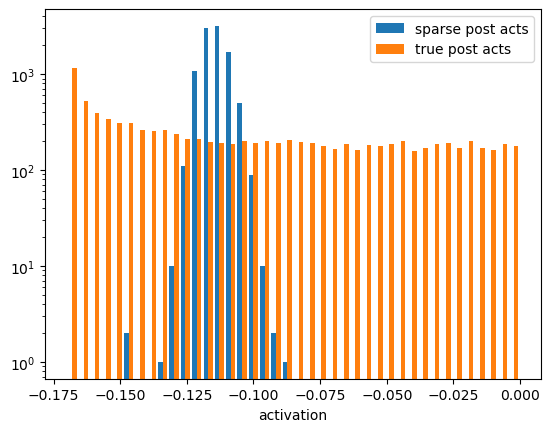

In [50]:
import matplotlib.pyplot as plt

sparse_post_acts = smlp.mlp.activation_fn(debug_acts[0].detach().cpu()).numpy()[0, 0]
true_post_acts = smlp.mlp.activation_fn(debug_acts[1].detach().cpu()).numpy()[0, 0]

print(true_post_acts[true_post_acts < 0].mean())

# plt.hist([sparse_post_acts[true_post_acts < 0], true_post_acts[true_post_acts < 0]], bins=40, histtype="bar", label=["sparse post acts", "true post acts"])
plt.hist([sparse_post_acts[true_post_acts < 0], true_post_acts[true_post_acts < 0]], bins=40, histtype="bar", label=["sparse post acts", "true post acts"])
# plt.hist(, bins=40, label='true post acts')
plt.legend()
plt.yscale("log")
plt.xlabel("activation")
plt.show()


In [56]:
import numpy as np
import time

def quick_test():
    mlp = model.model.layers[0].mlp

    # Use inner product as a "distance metric". This is actually perfect for our case though,
    # where MLP activations are scaled according to inner product.
    p = hnswlib.Index(space='ip', dim=mlp.fc1.in_features + 1)

    # Add weight matrix to encoder.
    p.init_index(max_elements=mlp.fc1.out_features)

    ids = np.arange(mlp.fc1.out_features)

    start_time = time.time()

    # mlp.fc1.weight.shape: [10240, 2560]
    # we add a bias so we can query for that inner product as well
    match_vecs = np.concatenate([
        mlp.fc1.weight.detach().cpu().numpy(),
        mlp.fc1.bias.detach().cpu().unsqueeze(-1).numpy(),
    ], axis=-1)
    p.add_items(match_vecs, ids)

    end_time = time.time()

    print(f"Created HNSW lookup table in {end_time - start_time:.4f} s")
    
    print((mlp.fc2.weight[:, [10, 20, 30, 40]] @ torch.tensor([1, 2, 3, 4], device='cuda', dtype=torch.float16)).shape)
    
    tokens = tokenizer("Sparse is fast", return_tensors="pt")

    embeddings = model.model.embed_tokens(tokens.input_ids.cuda())

    # ef should be greater than k.
    # it is the size of the list used during nearest neighbor search.
    num_neighbors = 100
    p.set_ef(int(num_neighbors * 2))

    embedding = np.zeros(2561)
    embedding[:-1] = embeddings[0, 0].detach().cpu().numpy()
    embedding[-1] = 1

    labels, _distances = p.knn_query(embedding, k=num_neighbors)

    # labels = np.arange(10240)
    labels = torch.tensor(labels.astype(np.int64), device="cuda").long()

    print(mlp.fc1.weight.shape)

    # recompute distances
    inner_products = mlp.fc1.weight[labels] @ embeddings[0, 0]

    # labels = np.arange(10240)
    # distances = 1 - match_vecs @ embeddings[0, 0].detach().cpu().numpy()

    # print(distances.shape)

    # print(labels.shape, distances.shape)

    # distances = 1 - inner product
    # labels = ids

    activations_recons = mlp.fc1.bias.data.clone()
    activations_recons[labels] += inner_products
    activations = mlp.activation_fn(activations_recons)
    reconstructed_activation = mlp.fc2.weight @ activations + mlp.fc2.bias

    # selected_decoder_vecs = mlp.fc2.weight[:, labels]
    # reconstructed_activation = torch.einsum('ds,s->d', mlp.fc2.weight, activations)

    # pre_activations = torch.tensor(1 - distances, device="cuda", dtype=mlp.fc2.weight.dtype)
    # activations = mlp.activation_fn(pre_activations)
    # selected_decoder_vecs = mlp.fc2.weight[:, labels]
    # reconstructed_activation = torch.einsum('ds,s->d', selected_decoder_vecs, activations)

    print(labels.shape)
    print(selected_decoder_vecs.shape)
    print(activations.shape)
    print(reconstructed_activation.shape)

    true_activation = mlp(embeddings[0, 0])

    print(torch.abs(reconstructed_activation - true_activation).sum())

    true_activation, reconstructed_activation


Created HNSW lookup table in 10.9962 s
